In [1]:
## The goal of this notebook is process the training data tweets,
## putting them into a form that can be used by a classification algorithm

In [2]:
## import necessary libraries
import os
import sys
import json
import csv
import pandas as pd
import numpy as np
from collections import Counter
import random
import math
import nltk
from nltk.corpus import stopwords
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import gc

## garbage collection
gc.collect();

## load the dataframe of (mostly) raw tweets
input_file = '../../tweet_data/training_data/training_data_unprocessed.pkl'
output_file = '../../tweet_data/training_data/training_data_processed.pkl'
output_file_cv = '../../tweet_data/training_data/training_data_cv_processed.pkl'
df = pd.read_pickle(input_file)

In [3]:
## take fraction of the data and scramble it
frac = 0.01
df = df.iloc[random.sample(range(0, len(df)), int(math.floor(frac*len(df))))]
df = df.reset_index(drop=True)

## print out some basic initial statistics
print 'initial number of tweets: ' + str(len(df))
print '  number of neutral tweets: ' + str(sum(df['sentiment']==0)) + ', ' + str(float(sum(df['sentiment']==0))/len(df)*100) + '%'
print '  number of positive tweets: ' + str(sum(df['sentiment']==1)) + ', ' + str(float(sum(df['sentiment']==1))/len(df)*100) + '%'
print '  number of negative tweets: ' + str(sum(df['sentiment']==-1)) + ', ' + str(float(sum(df['sentiment']==-1))/len(df)*100) + '%'

if sum(df['sentiment']==-1) + sum(df['sentiment']==0) + sum(df['sentiment']==1) != len(df):
  print 'Not all tweets classified as 1,0,-1!'

initial number of tweets: 25977
  number of neutral tweets: 4336, 16.6916888016%
  number of positive tweets: 10781, 41.5020980098%
  number of negative tweets: 10860, 41.8062131886%


In [4]:
## delete the duplicates
Noriginal = len(df)
df = df.drop_duplicates(subset='id', keep='last')
print 'duplicates deleted: ' + str(Noriginal - len(df))
df = df.reset_index(drop=True)
print 'current number of tweets: ' + str(len(df))

duplicates deleted: 1
current number of tweets: 25976


In [5]:
## delete the retweets
print 'number of retweets deleted: ' + str(sum(list(df['retweet'])))
df = df[[not i for i in list(df['retweet'])]]

number of retweets deleted: 7261


In [6]:
## drop the non-English tweets (most dropped tweets seem to actually be English...)
lang_drop = (df['lang']!='en')
print 'non-English tweets deleted: ' + str(sum(lang_drop))
df = df[list([not i for i in lang_drop])]
df = df.reset_index(drop=True)
print 'current number of tweets: ' + str(len(df))

non-English tweets deleted: 60
current number of tweets: 18655


In [7]:
## Preprocessing: set-up

## define a preprocessing function that 1) lowers the case, 2) tokenizes into words, 3) lemmatizes
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
def preprocess(sentence):
  return [wordnet_lemmatizer.lemmatize(word.lower()) for word in nltk.word_tokenize(sentence)]

## load the list of english stop words
stoplist = stopwords.words('english')

## set-up regular expressions to delete all non a-z characters
import re
regex = re.compile('[^a-zA-Z]')

## translation tables for dropping punctuation
## treat apostrophes differently from things like .,!
import string
punctuation = string.punctuation
punctuation_nospace = punctuation[6]
punctuation_space = [p for p in punctuation if p not in punctuation_nospace]
translate_table_nospace = dict((ord(char), None) for char in punctuation_nospace)   
translate_table_space = dict((ord(char), u' ') for char in punctuation_space)

## merge the tables
translate_table = translate_table_space.copy()
translate_table.update(translate_table_nospace) 

## load the list of emoticons
import codecs
f = codecs.open('../emoticons_positive.txt', encoding='utf-8')
pos_emoticons = []
for line in f:
  pos_emoticons.append(line[0:-1])
f = codecs.open('../emoticons_negative.txt', encoding='utf-8')
neg_emoticons = []
for line in f:
  neg_emoticons.append(line[0:-1])
all_emoticons = pos_emoticons + neg_emoticons
ASCII_all_emoticons = [e.encode("ascii","ignore") for e in all_emoticons]

## Preprocessing: implementation
words = []
new_text = []
for i in range(len(df)):
  text_dummy = df['text'].iloc[i]

  ## tokenize positive and negative emoticons
  ## also pad the token with spaces to catch even embedded tweets such as 'lame:('
  for j in range(len(pos_emoticons)):
    text_dummy = text_dummy.replace(pos_emoticons[j], ' posemoticontoken' + ' ')
  for j in range(len(neg_emoticons)):
    text_dummy = text_dummy.replace(neg_emoticons[j], ' negemoticontoken' + ' ')
  
  ## tokenize handles, hashtags, and url's
  text_dummy = text_dummy.replace('@', ' usernametoken') #this catches the '.@XXX' trick
  text_dummy = text_dummy.replace('#', ' hashtagtoken')
  while 'https://' in text_dummy:
    text_dummy = text_dummy[:text_dummy.index('https://')] +' urltoken ' + text_dummy[text_dummy.index('https://')+23:]
  while 'http://' in text_dummy:
    text_dummy = text_dummy[:text_dummy.index('http://')] +' urltoken ' + text_dummy[text_dummy.index('http://')+22:]
  
  ## replace html entities with space (note: 'and' is a stopword and so is dropped, so no need to treat & special)
  html_entities = [u'&nbsp;', u'&lt;', u'&gt;', u'&amp;', u'&quot;', u'&apos;', u'&cent;', u'&pound;', u'&yen;', u'&euro;', u'&copy;', u'&reg;']
  for html in html_entities:
    text_dummy = text_dummy.replace(html, '')
  
  ## drop punctuation, tokenize into words, lower the case, and lemmatize
  text_dummy = text_dummy.translate(translate_table)
  words_dummy = preprocess(text_dummy)

  ## remove stop words
  words_dummy = [w for w in words_dummy if not w in stoplist]
  
  ## anonymize the username_tokens
  for j in range(len(words_dummy)):
    if words_dummy[j][0:13] == 'usernametoken':
      words_dummy[j] = 'usernametoken'

  ## remove numbers
  words_dummy = [regex.sub('', w) for w in words_dummy if len(regex.sub('', w)) > 0]
  
  ## make a new sentence for easy vectorized manipulations
  words.append(words_dummy)
  new_text.append(" ".join(words_dummy))
df['words'] = words
df['new_text'] = new_text

In [8]:
## Refine sentiment assignment

## drop the tweets containing the wrong emoticon tokens
neutral_drop1 = (df['sentiment']==0) & (df['new_text'].str.contains('posemoticontoken'))
neutral_drop2 = (df['sentiment']==0) & (df['new_text'].str.contains('negemoticontoken'))
pos_drop1 = (df['sentiment']==1) & (df['new_text'].str.contains('negemoticontoken'))
neg_drop1 = (df['sentiment']==-1) & (df['new_text'].str.contains('posemoticontoken'))

## drop any positive/negative tweets not containing the appropriate emoticon token
## there are much more positive tweets dropped b/c :P was returned in the search query for :)
pos_drop2 = (df['sentiment']==1) & (df['new_text'].str.contains('posemoticontoken')==False)
neg_drop2 = (df['sentiment']==-1) & (df['new_text'].str.contains('negemoticontoken')==False)

droplist = list(neutral_drop1|neutral_drop2|pos_drop1|pos_drop2|neg_drop1|neg_drop2)
not_droplist = [not i for i in droplist]
print 'tweets to be dropped: ' + str(sum(droplist)) + ', ' + str(100*float(sum(droplist))/len(df)) + '%'
print '  neutral tweets to be dropped: ' + str(sum(list(neutral_drop1|neutral_drop2))) + ', ' + str(100*float(sum(list(neutral_drop1|neutral_drop2)))/sum(df['sentiment']==0)) + '%'
print '  positive tweets to be dropped: ' + str(sum(list(pos_drop1|pos_drop2))) + ', ' + str(100*float(sum(list(pos_drop1|pos_drop2)))/sum(df['sentiment']==1)) + '%'
print '  negative tweets to be dropped: ' + str(sum(list(neg_drop1|neg_drop2))) + ', ' + str(100*float(sum(list(neg_drop1|neg_drop2)))/sum(df['sentiment']==-1)) + '%'
df = df[list(not_droplist)]
df = df.reset_index(drop=True)

## drop 'new_text' to avoid mistakes as I continue to process 'words'
df.drop('new_text', axis=1, inplace=True)

tweets to be dropped: 594, 3.18413294023%
  neutral tweets to be dropped: 24, 0.662251655629%
  positive tweets to be dropped: 470, 6.8553092182%
  negative tweets to be dropped: 100, 1.22324159021%


In [9]:
## emoticon statistics
pos_emoticon_counter = 0
neg_emoticon_counter = 0
for i in range(len(df)):
  if df['sentiment'].iloc[i] == 1:
    pos_emoticon_counter += Counter(df['words'].iloc[i])['posemoticontoken']
  if df['sentiment'].iloc[i] == -1:
    neg_emoticon_counter += Counter(df['words'].iloc[i])['negemoticontoken']

print 'before dropping:'
print 'avg. positive emoticons per positive tweet:', float(pos_emoticon_counter)/sum(df['sentiment']==1)
print 'avg. negative emoticons per negative tweet:', float(neg_emoticon_counter)/sum(df['sentiment']==-1)

## throw away some fraction (to be treated as a hyperparameter) of the emoticons
## probably should treat +/- differently, for now let's treat as the same
pThreshold = 0.05 #fraction to keep
emoticoncounter = 0
droppedcounter = 0
for i in range(len(df)):
  for w in df['words'].iloc[i]:
    if w == 'posemoticontoken' or w == 'negemoticontoken':
      emoticoncounter += 1
      if random.random() > pThreshold:
        df['words'].iloc[i].remove(w)
        droppedcounter += 1
print 'dropped ' + str(100*float(droppedcounter)/emoticoncounter) + '% of emoticons'

before dropping:
avg. positive emoticons per positive tweet: 1.04791731914
avg. negative emoticons per negative tweet: 1.0386377709
dropped 95.0369872226% of emoticons


In [10]:
## split off a CV set
## split off a separate cv set from the training data (we already shuffled the data)
cvratio = 0.1 # fraction to split off
df_cv = df.copy(deep=True)
df_cv = df_cv.iloc[:int(math.floor(cvratio*len(df)))]
df_cv = df_cv.reset_index(drop=True)
df = df.iloc[int(math.floor(cvratio*len(df))):]
df = df.reset_index(drop=True)

print 'training data set size:', len(df)
print 'cv data set size:', + len(df_cv)

training data set size: 16255
cv data set size: 1806


In [11]:
## convert the list of words to a list of word ranks
words_tot = [item for sublist in df['words'] for item in sublist]
count = Counter(words_tot).most_common()
words_unique = [count[i][0] for i in range(len(count))]
words_frequencies = [count[i][1] for i in range(len(count))]

def word_to_rank(x):
  return sorted([ words_unique.index(w) for w in x if w in words_unique])

df['word_ranks'] = df['words'].map(word_to_rank)
df_cv['word_ranks'] = df_cv['words'].map(word_to_rank)

number of tweets: 16255
  number of neutral tweets: 3234, 19.8954167948%
  number of positive tweets: 5749, 35.3675792064%
  number of negative tweets: 7272, 44.7370039988%

training set statistics:
  total number of words: 119244
  total number of unique words: 18296
  lexical diversity: 0.153433296434


+------------------+-------+
| Word             | Count |
+------------------+-------+
| usernametoken    | 10875 |
| urltoken         |  6751 |
| im               |  1151 |
| u                |   783 |
| thanks           |   780 |
| want             |   650 |
| wa               |   647 |
| get              |   638 |
| like             |   624 |
| love             |   551 |
| dont             |   525 |
| day              |   510 |
| miss             |   509 |
| one              |   503 |
| negemoticontoken |   476 |
| good             |   472 |
| happy            |   458 |
| much             |   450 |
| know             |   434 |
| great            |   420 |
+------------------+------

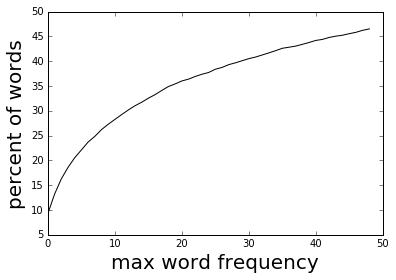

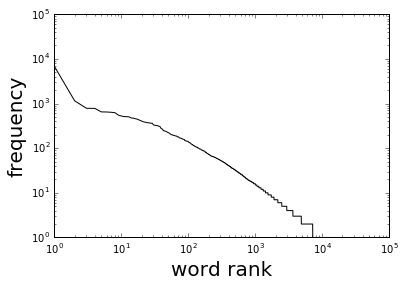

In [13]:
## print out some preliminary statistics

print 'number of tweets: ' + str(len(df))
print '  number of neutral tweets: ' + str(sum(df['sentiment']==0)) + ', ' + str(float(sum(df['sentiment']==0))/len(df)*100) + '%'
print '  number of positive tweets: ' + str(sum(df['sentiment']==1)) + ', ' + str(float(sum(df['sentiment']==1))/len(df)*100) + '%'
print '  number of negative tweets: ' + str(sum(df['sentiment']==-1)) + ', ' + str(float(sum(df['sentiment']==-1))/len(df)*100) + '%'

if sum(df['sentiment']==-1) + sum(df['sentiment']==0) + sum(df['sentiment']==1) != len(df):
  print 'Warning: not all tweets classified as 1,0,-1!'

## lexical diversity
def lexical_diversity(tokens):
    return 1.0*len(set(tokens))/len(tokens) 

print '\ntraining set statistics:'
print '  total number of words:', len(words_tot)
print '  total number of unique words:', len(words_unique)
print '  lexical diversity:', lexical_diversity(words_tot)

## examine word frequencies
print '\n'
pt = PrettyTable(field_names=['Word', 'Count']) 
[ pt.add_row(kv) for kv in count[:20] ]
pt.align['Word'], pt.align['Count'] = 'l', 'r' #set column alignment
print pt

## get a sense for the frequency distribution of words
## what % of words occur with frequency <= x
maxwordfreq = [100.0*c*words_frequencies.count(c)/len(words_tot) for c in range(1,50)]
for i in range(1,len(maxwordfreq)):
  maxwordfreq[i] += maxwordfreq[i-1]
%matplotlib inline
plt.plot(maxwordfreq, c='black')
plt.ylabel('percent of words', fontsize=20)
plt.xlabel('max word frequency', fontsize=20)
plt.savefig('../figures/training_percentofwords.png')
plt.show()

## plot frequency(rank)
words_tot_counts = sorted(Counter(words_tot).values(), reverse=True)
plt.loglog(words_tot_counts, c='black')
plt.ylabel('frequency', fontsize=20)
plt.xlabel('word rank', fontsize=20)
plt.savefig('../figures/training_frequencyrank.png')
plt.show()

In [14]:
## save the processed data
df_final = df.copy(deep=True)
df_final = df_final.drop([l for l in list(df.columns.values) if l not in ['sentiment','words','word_ranks']], axis=1)
df_final.to_pickle(output_file)

df_cv_final = df_cv.copy(deep=True)
df_cv_final = df_cv_final.drop([l for l in list(df.columns.values) if l not in ['sentiment','words','word_ranks']], axis=1)
df_cv_final.to_pickle(output_file_cv)